Code to build and save various hidden weight initializations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json

## Utility

In [2]:
def plot_weight_heatmap(W, title="W", symmetric=True):
    """Heatmap + colorbar with optional symmetric limits."""
    vlim = np.max(np.abs(W)) if symmetric else None
    plt.figure(figsize=(5, 4))
    plt.imshow(
        W,
        aspect="auto",
        origin="lower",
        vmin=(-vlim if symmetric else None),
        vmax=(vlim if symmetric else None),
    )
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Columns (j)")
    plt.ylabel("Rows (i)")
    plt.tight_layout()
    plt.show()

In [3]:
def plot_weight_hist(W, bins=60, title="W values"):
    """Value distribution."""
    plt.figure(figsize=(5, 3))
    plt.hist(W.ravel(), bins=bins)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_eigenspectrum(W, title="eig(W)"):
    """Eigenvalues in the complex plane + spectral radius."""
    eig = np.linalg.eigvals(W)
    radius = np.max(np.abs(eig))
    plt.figure(figsize=(4, 4))
    plt.scatter(eig.real, eig.imag, s=10)
    circle = plt.Circle((0, 0), radius, fill=False, linestyle="--")
    ax = plt.gca()
    ax.add_artist(circle)
    ax.axhline(0, lw=0.5, color="k")
    ax.axvline(0, lw=0.5, color="k")
    ax.set_aspect("equal", "box")
    plt.title(f"{title} | spectral radius ≈ {radius:.3f}")
    plt.tight_layout()
    plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def plot_weight_all(W, title="Weights", symmetric=True, bins=60):
    """Plot heatmap, histogram, and eigenspectrum in one figure (3 rows, 1 col)."""
    eig = np.linalg.eigvals(W)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # --- Heatmap ---
    vlim = np.max(np.abs(W)) if symmetric else None
    im = axes[0].imshow(
        W,
        aspect="auto",
        origin="lower",
        vmin=(-vlim if symmetric else None),
        vmax=(vlim if symmetric else None),
    )
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
    axes[0].set_title(f"{title} Heatmap")

    # --- Histogram ---
    axes[1].hist(W.ravel(), bins=bins)
    axes[1].set_title(f"{title} Histogram")

    # --- Eigenspectrum ---
    radius = np.max(np.abs(eig))
    axes[2].scatter(eig.real, eig.imag, s=10)
    circle = plt.Circle((0, 0), radius, fill=False, linestyle="--")
    axes[2].add_artist(circle)
    axes[2].axhline(0, lw=0.5, color="k")
    axes[2].axvline(0, lw=0.5, color="k")
    axes[2].set_aspect("equal", "box")
    axes[2].set_title(f"{title} eigvals | spectral radius ≈ {radius:.3f}")

    plt.tight_layout()
    plt.show()

In [6]:
def xavier_variance(fan_in, fan_out, gain=1.0):
    # Xavier/Glorot normal: std = gain * sqrt(2 / (fan_in + fan_out))
    # → variance = gain^2 * 2 / (fan_in + fan_out)
    return (gain**2) * 2.0 / (fan_in + fan_out)

In [7]:
def save_matrix(W, save_dir, name, meta=None):
    """
    Saves W as .npy and optional metadata as .json (same basename).
    """
    os.makedirs(save_dir, exist_ok=True)
    base = os.path.join(save_dir, name)
    np.save(base + ".npy", W)
    if meta is not None:
        with open(base + ".json", "w") as f:
            json.dump(meta, f, indent=2)
    print(f"Saved: {base}.npy" + (" and .json" if meta is not None else ""))

## Weight matrices

### Shift matrix

In [8]:
def build_he(
    n_in, n_out, nonlinearity="relu", mode="fan_in", dist="normal", a=0.0, seed=None
):
    """
    He/Kaiming initialization.
    - nonlinearity: 'relu' or 'leaky_relu' (set a to negative_slope for leaky)
    - mode: 'fan_in' (forward activations) or 'fan_out' (backward gradients)
    - dist: 'normal' or 'uniform'
    - a: negative_slope for leaky ReLU (0.0 for ReLU)
    """
    rng = np.random.default_rng(seed)
    fan_in = n_in
    fan_out = n_out
    fan = fan_in if mode == "fan_in" else fan_out

    # gain per He/Kaiming
    if nonlinearity == "leaky_relu":
        gain = np.sqrt(2.0 / (1.0 + a**2))
    else:  # relu
        gain = np.sqrt(2.0)

    std = gain / np.sqrt(fan)

    if dist == "uniform":
        bound = np.sqrt(3.0) * std  # matches kaiming_uniform
        W = rng.uniform(-bound, bound, size=(n_out, n_in))
    else:
        W = rng.normal(0.0, std, size=(n_out, n_in))

    return W

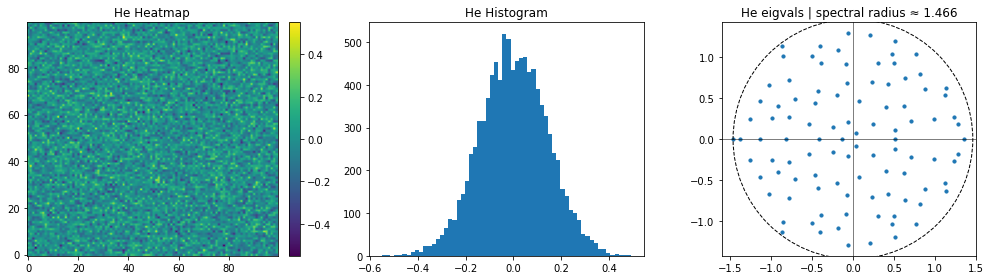

In [9]:
n = 100
W_he = build_he(
    n_in=n, n_out=n, nonlinearity="relu", mode="fan_in", dist="normal", seed=0
)
plot_weight_all(W_he, title="He")

In [10]:
def build_xavier(n_in, n_out, gain=1.0, seed=None):
    """Xavier/Glorot normal."""
    rng = np.random.default_rng(seed)
    std = gain * np.sqrt(2.0 / (n_in + n_out))
    W = rng.normal(0.0, std, size=(n_out, n_in))
    mean = W.mean()
    var = ((W - mean) ** 2).mean()
    return W, mean, var

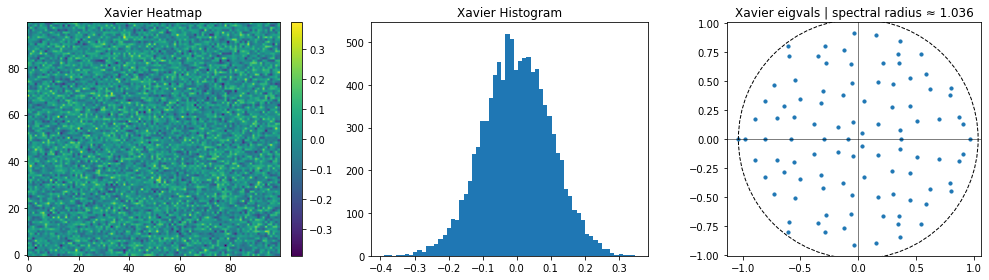

Xavier variance: : 0.009962


In [11]:
W_xavier, mean_xavier, var_xavier = build_xavier(n_in=n, n_out=n, seed=0)
plot_weight_all(W_xavier, title="Xavier")
print(f"Xavier variance: : {var_xavier:.6f}")

In [14]:
def build_shift(n, off=1.0, target_var=None, cyclic=False, verbose=None):
    """Upper shift (superdiagonal = off)."""
    print("Building shift matrix")
    W = np.zeros((n, n), dtype=np.float32)
    idx = np.arange(n - 1)
    W[idx, idx + 1] = off
    if cyclic:
        W[-1, 0] = off

    # calculate empirical mean and variance
    var_emp = float(((W - W.mean()) ** 2).mean())
    if verbose:
        print(f"Variance prior to scaling: {var_emp:.6f}")

    # scale to xavier variance
    if target_var is not None and var_emp > 0:
        scale = np.sqrt(target_var / var_emp)
        W = (W * scale).astype(np.float32)
        var_scaled = float(((W - W.mean()) ** 2).mean())
        if verbose:
            print(f"Variance after scaling: {var_scaled:.6f}")

    return W

Building shift matrix
Variance prior to scaling: 0.009802
Variance after scaling: 0.010000


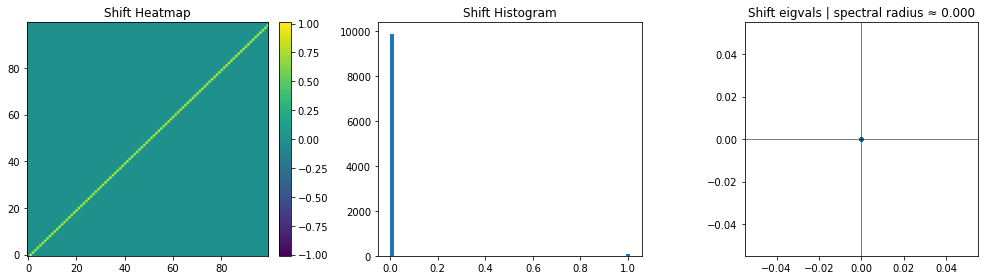

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/hidden_shift_n100_xavier.npy and .json


In [21]:
target_var = xavier_variance(n, n, gain=1)
W_shift = build_shift(n, off=1.0, target_var=target_var, cyclic=False, verbose=True)
plot_weight_all(W_shift, title="Shift")

save_matrix(
    W_shift,
    save_dir="../data/Ns100_SeqN100/hidden-weight-inits",
    name=f"hidden_shift_n{n}_xavier",
    meta={
        "type": "shift",
        "n": n,
        "target_var": target_var,
        "note": "scaled to Xavier variance. Not cyclic.",
    },
)

Building shift matrix
Variance prior to scaling: 0.009900
Variance after scaling: 0.010000


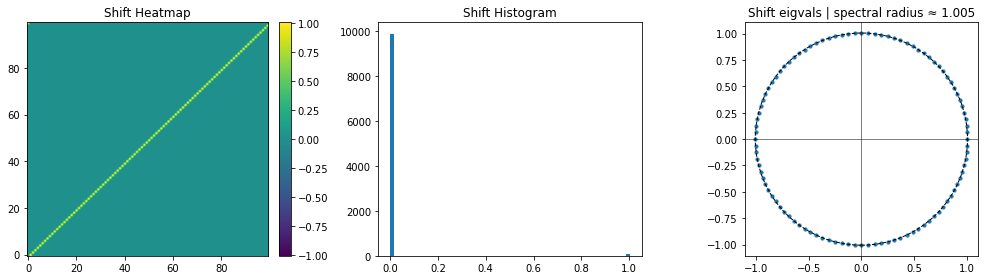

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/hidden_cyclic_shift_n100_xavier.npy and .json


In [22]:
target_var = xavier_variance(n, n, gain=1)
W_shift = build_shift(n, off=1.0, target_var=target_var, cyclic=True, verbose=True)
plot_weight_all(W_shift, title="Shift")

save_matrix(
    W_shift,
    save_dir="../data/Ns100_SeqN100/hidden-weight-inits",
    name=f"hidden_cyclic_shift_n{n}_xavier",
    meta={
        "type": "cyclic_shift",
        "n": n,
        "target_var": target_var,
        "note": "scaled to Xavier variance. Not cyclic.",
    },
)

# Others

In [ ]:
def build_tridiag(n, diag=1.0, off=-1.0, cyclic=False):
    """(Cyclic) tridiagonal with diag and off-diagonals."""
    W = np.zeros((n, n))
    i = np.arange(n)
    W[i, i] = diag
    W[i[1:], i[:-1]] = off  # sub
    W[i[:-1], i[1:]] = off  # super
    if cyclic:
        W[0, -1] = off
        W[-1, 0] = off

    # calculate empirical mean and variance
    mean = W.mean()
    var = ((W - mean) ** 2).mean()
    print(f"Variance prior to scaling: {var:.6f}")

    # scale to xavier variance
    scale = (var_xavier / var) ** (0.5)
    W_scaled = W * scale
    print(f"Variance after scaling: {W_scaled.var().item():.6f}")

    return W

Variance prior to scaling: 0.028912
Variance after scaling: 0.009962


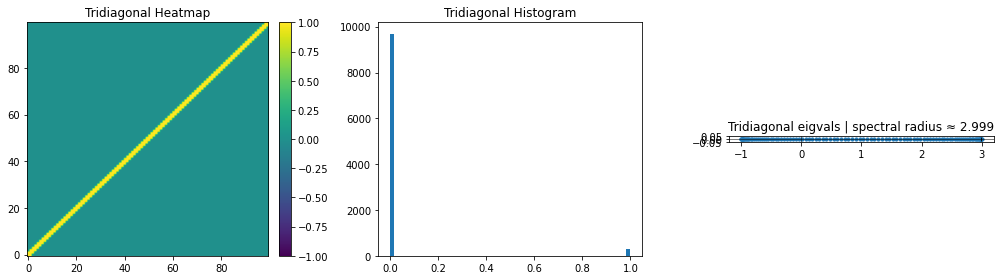

In [86]:
W_tridiag = build_tridiag(n, off=1.0)
plot_weight_all(W_tridiag, title="Tridiagonal")

Variance prior to scaling: 0.029100
Variance after scaling: 0.009962


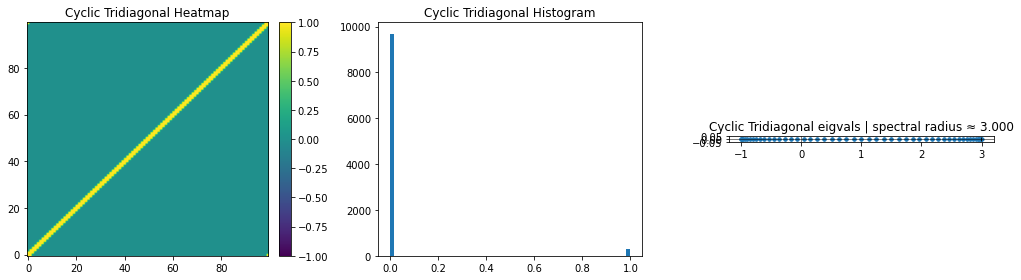

In [87]:
W_cyclic_tridiag = build_tridiag(n, off=1.0, cyclic=True)
plot_weight_all(W_cyclic_tridiag, title="Cyclic Tridiagonal")

In [ ]:
def build_mexican_hat(
    n, sigma_exc=2.0, sigma_inh=6.0, a_exc=1.0, a_inh=0.5, cyclic=True
):
    """
    Mexican-hat (DoG) kernel on a ring (default) or line.
    Returns a circulant (if cyclic) or Toeplitz-like weight.
    """
    x = np.arange(n)
    sigma = n / 10
    center = size // 2

    def circ_dist(i, j):
        d = np.abs(i - j)
        return np.minimum(d, n - d)  # ring distance

    W = np.zeros((n, n))
    for i in range(n):
        d = circ_dist(i, x) if cyclic else np.abs(i - x)
        exc = a_exc * np.exp(-(d**2) / (2 * sigma_exc**2))
        inh = a_inh * np.exp(-(d**2) / (2 * sigma_inh**2))
        W[i, :] = exc - inh
    # zero the diagonal if you want pure lateral interactions
    np.fill_diagonal(W, 0.0)
    return W

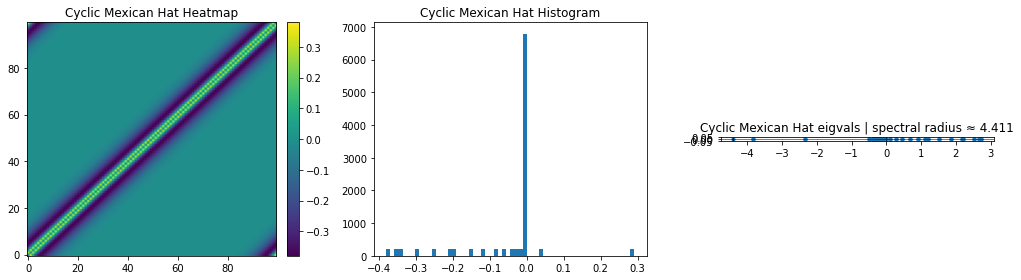

In [62]:
W_mexhat = build_mexican_hat(
    n, sigma_exc=2.0, sigma_inh=6.0, a_exc=1.0, a_inh=0.6, cyclic=True
)
plot_weight_all(W_mexhat, title="Cyclic Mexican Hat")

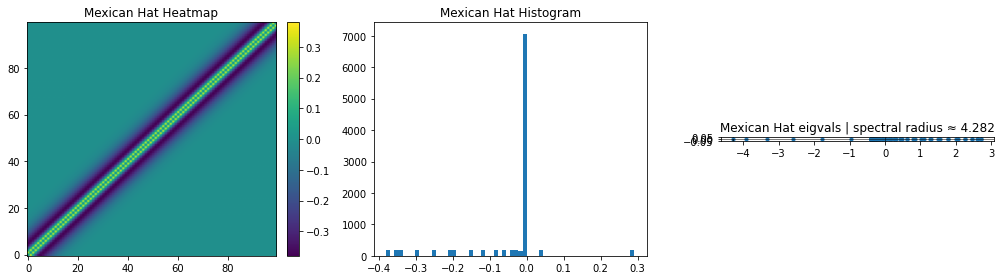

In [63]:
W_mexhat = build_mexican_hat(
    n, sigma_exc=2.0, sigma_inh=6.0, a_exc=1.0, a_inh=0.6, cyclic=False
)
plot_weight_all(W_mexhat, title="Mexican Hat")

In [64]:
def build_orthogonal(n, scale=1.0, seed=None):
    """Random orthogonal with optional scaling."""
    rng = np.random.default_rng(seed)
    A = rng.normal(size=(n, n))
    # QR gives orthonormal columns in Q
    Q, R = np.linalg.qr(A)
    # Fix sign ambiguity
    Q *= np.sign(np.diag(R))
    return scale * Q

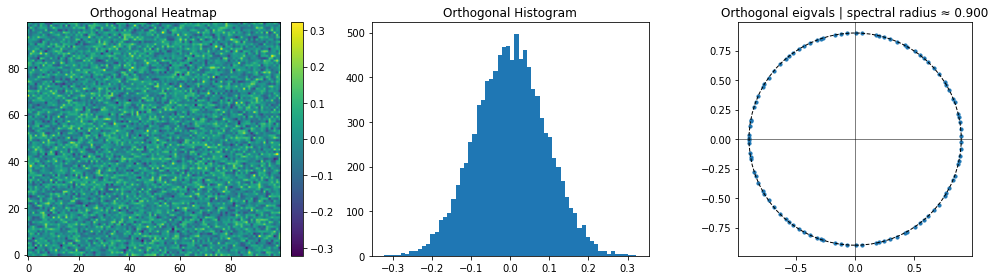

In [65]:
W_orth = build_orthogonal(n, scale=0.9, seed=0)
plot_weight_all(W_orth, title="Orthogonal")